# Оглавление
## [0. Загрузка необходимых библиотек](#cell1)
* ### [Описание базы данных](#cell2)
## [1. Формирование таблицы](#cell3)
* ### [Итоговая таблица](#cell4)
## [2. Проведение тестов](#cell5)
* ### [Тест Колмогорова-Смирнова](#cell6)
* ### [Тест Стьюдента](#cell7)
    * #### [Тест стьюдента в разных секторах](#cell8)
    * #### [Дополнение к KS test](#cell9)
## [3. Линейная регрессия](#cell11)
* ### [Модели №1](#cell12)
    * #### [Результаты модели №1](#cell20)
* ### [Модель №2](#cell13)
    * #### [Результаты модели №2](#cell21)
* ### [Модель №3](#cell16)
    * #### [Мультиколлинеарность](#cell14)
    * #### [Тест Уайта](#cell15)
    * #### [Результаты модели №3](#cell30)
* ### [Модель №4](#cell31)
    * #### [Результаты модели №4](#cell32)
* ### [Итоговая модель](#cell23)

# 0. Загрузка необходимых библиотек
<a id="cell1"></a>

In [415]:
#Парсинг, API, работа с таблицей
import pandas as pd
import numpy as np
import requests
import csv
from bs4 import BeautifulSoup
from itertools import combinations

#Визуализация
from matplotlib import pyplot as plt
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
import plotly.express as px

#Тесты
from scipy.stats import ks_2samp
from scipy.stats import kstest
import scipy.stats as stats
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
import seaborn as sns

# Описание базы данных
<a id="cell2"></a>

### В качестве исследования была взята динамика цен акций c 2021 - 2023 год входящих в Индекс Московской Биржи (IMOEX)
### Целью исследования является выявление закономерностей между ценами акций и определение компонентов IMOEX, способных влиять на цену акций MTS

* #### Используемые термины: Тикер - это сокращенные кодифицированные обозначения ценных бумаг

# 1. Формирование таблицы
<a id="cell3"></a>

In [416]:
#Создадим парсер, который собирает информацию c сайта tradingview о тикетах и секторе каждой компании
url = "https://ru.tradingview.com/symbols/MOEX-IMOEX/components/"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
    
#Таблица, в которой содержатся интересующие нас тикеты
table = soup.find('tbody', {'tabindex': "100"})
#Пустой словарь, в котором будут содержатся пары (название тикера, название сектора)
tickets = {}

#Процесс сбора информации
for row in table.find_all('tr')[1:]:
    ticket = row.find('a', {'class': 'apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat'}).text
    sector = row.find('a', {'class': 'link-KcaOqbQP apply-common-tooltip'}).text
    tickets[ticket] = sector

In [417]:
# Cоздаем файл с динамикой интересующих аспектов каждой компании
with open('companies.csv', 'w', encoding='UTF-8') as companies:
    # Пустой список, в котором будут содержаться датафреймы будущих компаний
    df = []

    #Процесс формирования списка df
    for ticket in tickets:

        #Формирование ссылки для сбора информации с сайта MOEX
        first_part = "http://iss.moex.com/iss/engines/stock/markets/shares/securities/"
        name_tiker = str(ticket)
        second_part = "/candles.json?from=" 
        #Год начала
        year_from = '2021'
        third_part = "-01-01&till="
        #Год конца
        year_to = '2024'
        last_part = "-03-20&interval=24"
        #Готовая ссылка
        link = first_part + name_tiker + second_part + year_from + third_part + year_to + last_part
        
        #Считывание ссылки
        j = requests.get(link).json()
        data = [{k : r[i] for i, k in enumerate(j['candles']['columns'])} for r in j['candles']['data']]
        data = pd.DataFrame(data)

        #Создание средней цены акции одной компании для каждого дня
        data['Средняя цена'] = data[['open', 'close']].sum(axis=1) / 2
        #Форматирование даты до year-month-day
        data['date'] = data['end'].str[:10]
        #Удаление ненужных столбцов
        data.drop(['open', 'close', 'high', 'low', 'close', 'value', 'begin', 'end'], axis=1 , inplace=True) 
        #Добавление столбца сектор
        data['Сектор'] = tickets[ticket]
        #Переименование столбца объем
        data.rename(columns={'volume':'Объем'}, inplace = True )
        
        #Приписывание тикетов к названием столбцов
        data = data.add_suffix(f' {ticket}')
        
        #Добавление датасета с компанией в список df
        df.append(data)
    
    #Присоединяем все таблицы из списка df друг к другу по горизионтали
    result = pd.concat(df, axis=1)
    #Записываем в файл
    result.to_csv(companies, encoding = 'UTF-8')
    
#Устанавливаем index_col=0 для удаление безымянного индекса (дублирует обычный индекс) 
cp = pd.read_csv('companies.csv', index_col=0)
#Замена обычного индекса на дату
cp.set_index('date MTSS', inplace=True)
cp.index.rename('Дата', inplace=True )

## Итоговая таблица
<a id="cell4"></a>

In [418]:
#Удалим строчки, о ценах которых ничего нет
cp.dropna(inplace=True)
cp

,Объем AFLT,Средняя цена AFLT,date AFLT,Сектор AFLT,Объем AGRO,Средняя цена AGRO,date AGRO,Сектор AGRO,Объем ALRS,Средняя цена ALRS,...,date UPRO,Сектор UPRO,Объем VKCO,Средняя цена VKCO,date VKCO,Сектор VKCO,Объем VTBR,Средняя цена VTBR,date VTBR,Сектор VTBR
Дата,,,,,,,,,,,,,,,,,,,,,
2021-01-04,17724460,71.91,2021-01-04,Транспорт,78367,836.9,2021-01-04,Обрабатывающая промышленность,9083700,98.955,...,2021-01-04,Коммунальные услуги,1784849,905.9,2021-12-14,Технологии,23944330000,0.038012,2021-01-04,Финансы
2021-01-05,13120660,72.37,2021-01-05,Транспорт,244870,862.0,2021-01-05,Обрабатывающая промышленность,9984020,99.030,...,2021-01-05,Коммунальные услуги,2234113,930.5,2021-12-15,Технологии,28792370000,0.038185,2021-01-05,Финансы
2021-01-06,18478850,72.92,2021-01-06,Транспорт,352442,894.8,2021-01-06,Обрабатывающая промышленность,17378330,100.460,...,2021-01-06,Коммунальные услуги,2446405,974.4,2021-12-16,Технологии,25475760000,0.038407,2021-01-06,Финансы
2021-01-08,16300610,73.44,2021-01-08,Транспорт,186402,906.5,2021-01-08,Обрабатывающая промышленность,23587700,102.880,...,2021-01-08,Коммунальные услуги,1109841,972.5,2021-12-17,Технологии,39651860000,0.038727,2021-01-08,Финансы
2021-01-11,26110910,73.73,2021-01-11,Транспорт,212175,900.4,2021-01-11,Обрабатывающая промышленность,32495880,105.375,...,2021-01-11,Коммунальные услуги,1132410,934.6,2021-12-20,Технологии,60323050000,0.039317,2021-01-11,Финансы
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-11,20633050,27.24,2023-01-11,Транспорт,52454,689.7,2023-01-17,Обрабатывающая промышленность,12277940,60.325,...,2023-01-13,Коммунальные услуги,3319236,687.7,2024-01-31,Технологии,52826330000,0.016502,2023-01-11,Финансы
2023-01-12,12463500,27.63,2023-01-12,Транспорт,160692,677.9,2023-01-18,Обрабатывающая промышленность,8473450,60.450,...,2023-01-16,Коммунальные услуги,2906551,692.1,2024-02-01,Технологии,30846440000,0.016680,2023-01-12,Финансы
2023-01-13,9939670,27.60,2023-01-13,Транспорт,56329,665.4,2023-01-19,Обрабатывающая промышленность,7023410,60.070,...,2023-01-17,Коммунальные услуги,2304794,681.6,2024-02-02,Технологии,41121110000,0.016610,2023-01-13,Финансы


# 2. Проведение тестов
<a id="cell5"></a>

## Тест Колмогорова-Смирнова
<a id="cell6"></a>
* #### Далее проводится двухвыборочный KS test на совпадение двух функций распределений

In [419]:
#Декартово произведение всех тикетов
tickets_comb = np.array(list(combinations(tickets.keys(), 2)))
#Пустой словарь из всех p_value, полученных в тесте KS и комбинации тикетов
tickets_pv_ks = {}

#Процесс заполнения массива pv_ks
for ticket in tickets_comb:
    #Создание выборки: Прирост цены акции в %
    c1 = cp[f'Средняя цена {ticket[0]}'] / cp[f'Средняя цена {ticket[0]}'].iloc[0]
    c2 = cp[f'Средняя цена {ticket[1]}'] / cp[f'Средняя цена {ticket[1]}'].iloc[0]

    #Добавление pv_ks и комбинацию тикетов в словарь
    tickets_pv_ks[(str(ticket[0]), str(ticket[1]))] = ks_2samp(c1, c2).pvalue

### Разделение тикеров, на те которые удовлетворяют и не удоавлетворяют гипотезе H0 при уровне значимости 5%

In [420]:
#Cортировка словаря по убыванию (по значению словаря)
sorted_tickets_pv_ks = sorted(tickets_pv_ks.items(), key=lambda x: x[1], reverse=True)

#Тикеры p_value >= 0.05
tickets_pv_ks_h0 = list(filter(lambda x: x[1] >= 0.05, sorted_tickets_pv_ks))
#Тикеры p_value < 0.05
tickets_pv_ks_h1 = list(filter(lambda x: x[1] < 0.05, sorted_tickets_pv_ks))

### Ниже можно рассмотреть отдельные пары графиков приростов цен акций, в которых гипотеза H0 (K-S) не отвергается. 
- #### На графики есть опция самостоятельного выбора нужных тикеров с соответствующими им p-value

In [421]:
#Cписок названий столбцов вида: Средняя цена акции <тикер>
price_columns = [column for column in cp if column.startswith('Средняя цена ')]

app = Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id="time-series-chart"),
    html.P("Выберите комбинацию тикеров:"),
    dcc.Dropdown(
        id="ticker",
        #Варианты выбора комбинаций тикеров с соответствующими p-value >= 0.05
        options=list(map(lambda x: f'{x[0][0]} — {x[0][1]}, p-value={round(x[1], 3)}', tickets_pv_ks_h0)),
        #Значение тикера выбирающиеся по-умолчанию
        value="SBER — SBERP, p-value=0.514",
        clearable=False,
    ),
])

@app.callback(
    Output("time-series-chart", "figure"), 
    Input("ticker", "value"))

def display_time_series(ticker):
    #Выбор колонок с приростами средних ценами всех компаний
    df = cp[price_columns] / cp[price_columns].iloc[0]
    #Удаление из столбцов "Средняя цена акции" (оставляется только тикет, с целью отсутсвтия дублирования в легенде) 
    df.columns = df.columns.str[13:]
    
    #Построение графиков (В x передаются индексы таблицы - дата [передать через срез нельзя], в y передается список колонок, идущих в срез df)
    fig = px.line(df, x=df.index, y=[f'{ticker.split("—")[0].strip()}', f'{ticker.split("—")[1].split(",")[0].strip()}'])    
    #Обновление названия оси ординат (из-за того, что передаваемый список в y сбросил название ординат [должна была передаваться строчка])
    fig.update_yaxes(title=dict(text=f'Прирост цен {ticker.split("—")[0].strip()} — {ticker.split("—")[1].split(",")[0].strip()}'))
    #Обновление названия колонки с легендами
    fig.update_layout(title=dict(text='Прирост средних цен в течение года', x=0.5, font=dict(size=20)),
                      legend_title_text='Тикеры', font=dict(size=15))
    return fig

app.run_server(debug=True)

### Выведем топ 2 пары тикеров по p-value (KS test) в порядке убывания

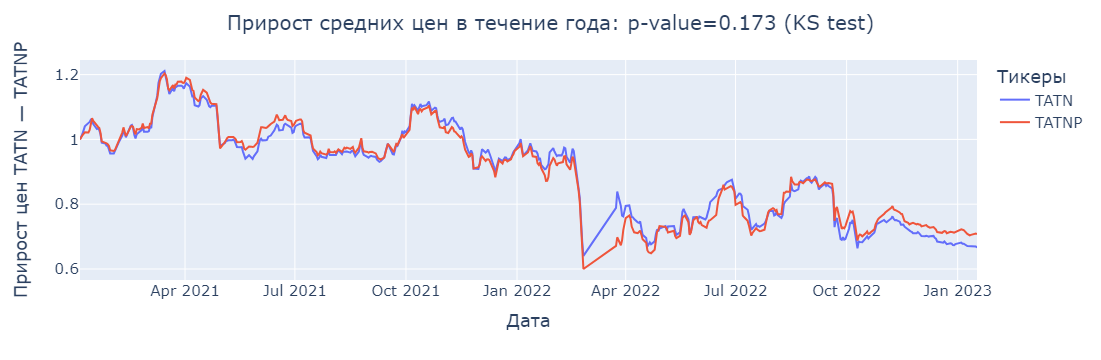

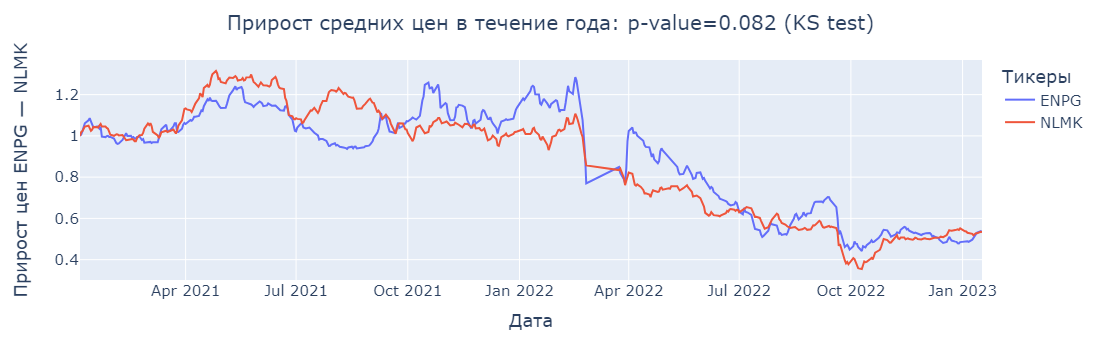

In [422]:
df = cp[price_columns] / cp[price_columns].iloc[0]
#Удаление из столбцов "Средняя цена акции" (оставляется только тикет, с целью отсутсвтия дублирования в легенде) 
df.columns = df.columns.str[13:]

for i in list(map(lambda x: f'{x[0][0]} — {x[0][1]}, p-value={round(x[1], 3)}', tickets_pv_ks_h0))[:3]:    
    #Построение графиков (В x передаются индексы таблицы - дата [передать через срез нельзя], в y передается список колонок, идущих в срез df)
    fig = px.line(df, x=df.index, y=[f'{i.split("—")[0].strip()}', f'{i.split("—")[1].split(",")[0].strip()}'])    
    #Обновление названия оси ординат (из-за того, что передаваемый список в y сбросил название ординат [должна была передаваться строчка])
    fig.update_yaxes(title=dict(text=f'Прирост цен {i.split("—")[0].strip()} — {i.split("—")[1].split(",")[0].strip()}'))
    #Обновление названия колонки с легендами
    fig.update_layout(title=dict(text=f'Прирост средних цен в течение года: {i.split("—")[1].split(",")[1].strip()} (KS test)', 
                      x=0.5, font=dict(size=20)),
                      legend_title_text='Тикеры', font=dict(size=15))
    fig.show()

## Тест Стьюдента
<a id="cell7"></a>
* #### Далее используется двухвыборочный Student test на совпадение математических ожиданий случайных величин
### Узнаем существуют ли такие пары акций, у которых математические ожиданя прироста цен, а значит и доходности от их покупки могут совпадать

In [423]:
#Пустой словарь из всех p_value, полученных в тесте Student и комбинации тикетов
tickets_pv_st = {}

#Процесс заполнения массива pv_ks
for ticket in tickets_comb:
    #Нормализация выборки
    c1 = cp[f'Средняя цена {ticket[0]}'] / cp[f'Средняя цена {ticket[0]}'].iloc[0]
    c2 = cp[f'Средняя цена {ticket[1]}'] / cp[f'Средняя цена {ticket[1]}'].iloc[0]

    #Добавление pv_ks и комбинацию тикетов в словарь
    tickets_pv_st[(str(ticket[0]), str(ticket[1]))] = stats.ttest_ind(c1, c2).pvalue

### Разделение тикеров, на те которые удовлетворяют и не удоавлетворяют гипотезе H0 при уровне значимости 5%

In [424]:
#Cортировка словаря по убыванию (по значению словаря)
sorted_tickets_pv_st = sorted(tickets_pv_st.items(), key=lambda x: x[1], reverse=True)

#Тикеры p_value >= 0.05
tickets_pv_st_h0 = list(filter(lambda x: x[1] >= 0.05, sorted_tickets_pv_st))
#Тикеры p_value < 0.05
tickets_pv_st_h1 = list(filter(lambda x: x[1] < 0.05, sorted_tickets_pv_st))

### Ниже можно рассмотреть отдельные пары графиков цен акций, в которых гипотеза H0 (St) не отвергается. 
- #### На графики есть опция самостоятельного выбора нужных тикеров с соответствующими им p-value

In [425]:
#Cписок названий столбцов вида: Средняя цена акции <тикер>
price_columns = [column for column in cp if column.startswith('Средняя цена ')]

app = Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id="time-series-chart"),
    html.P("Выберите комбинацию тикеров:"),
    dcc.Dropdown(
        id="ticker",
        #Варианты выбора комбинаций тикеров с соответствующими p-value >= 0.05
        options=list(map(lambda x: f'{x[0][0]} — {x[0][1]}, p-value={round(x[1], 3)}', tickets_pv_st_h0)),
        #Значение тикера выбирающиеся по-умолчанию
        value="ENPG — FEES, p-value=0.913",
        clearable=False,
    ),
])

@app.callback(
    Output("time-series-chart", "figure"), 
    Input("ticker", "value"))

def display_time_series(ticker):
    #Выбор колонок с приростами средних цен всех компаний
    df = cp[price_columns] / cp[price_columns].iloc[0]
    #Удаление из столбцов "Средняя цена акции" (оставляется только тикет, с целью отсутсвтия дублирования в легенде) 
    df.columns = df.columns.str[13:]
    
    #Построение графиков (В x передаются индексы таблицы - дата [передать через срез нельзя], в y передается список колонок, идущих в срез df)
    fig = px.line(df, x=df.index, y=[f'{ticker.split("—")[0].strip()}', f'{ticker.split("—")[1].split(",")[0].strip()}'])    
    #Обновление названия оси ординат (из-за того, что передаваемый список в y сбросил название ординат [должна была передаваться строчка])
    fig.update_yaxes(title=dict(text=f'Прирост цен {ticker.split("—")[0].strip()} — {ticker.split("—")[1].split(",")[0].strip()}'))
    #Обновление названия колонки с легендами
    fig.update_layout(title=dict(text='Прирост средних цен в течение 2 лет', x=0.5, font=dict(size=20)),
                      legend_title_text='Тикеры', font=dict(size=15))
    return fig

app.run_server(debug=True)

### Выведем топ 3 пар тикеров по p-value (St test) в порядке убывания

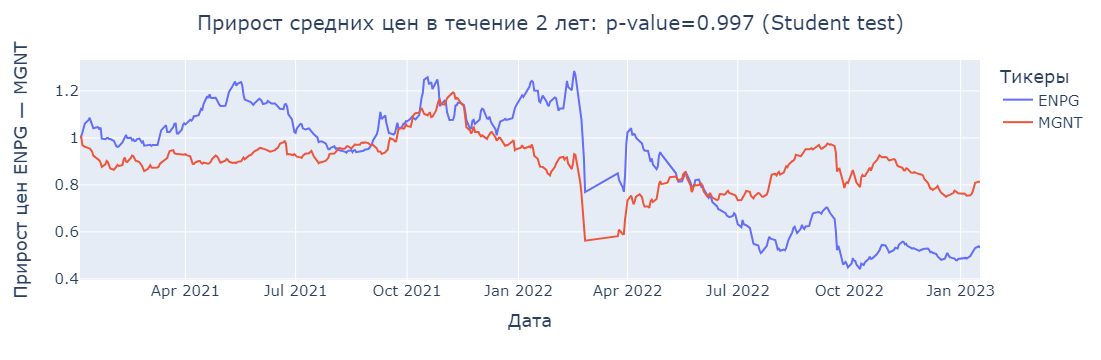

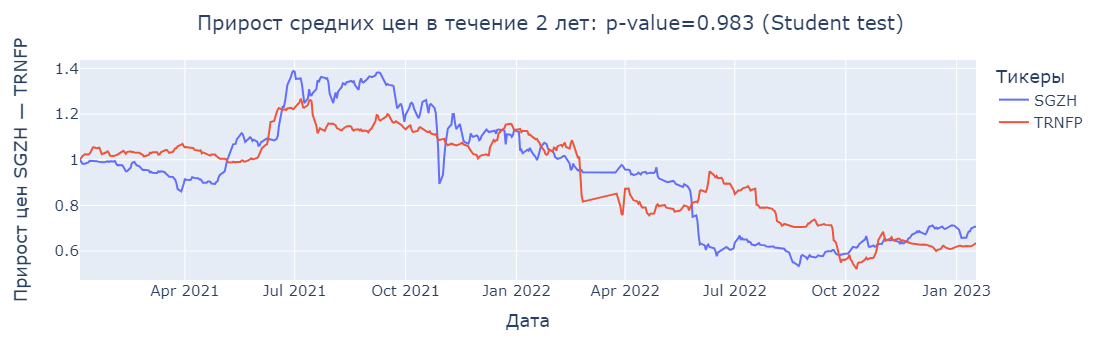

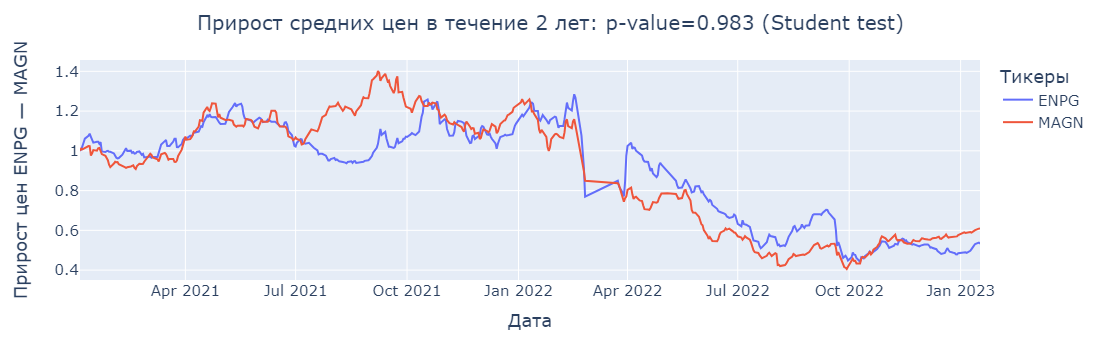

In [426]:
df = cp[price_columns] / cp[price_columns].iloc[0]
#Удаление из столбцов "Средняя цена акции" (оставляется только тикет, с целью отсутсвтия дублирования в легенде) 
df.columns = df.columns.str[13:]

for i in list(map(lambda x: f'{x[0][0]} — {x[0][1]}, p-value={round(x[1], 3)}', tickets_pv_st_h0))[:3]:    
    #Построение графиков (В x передаются индексы таблицы - дата [передать через срез нельзя], в y передается список колонок, идущих в срез df)
    fig = px.line(df, x=df.index, y=[f'{i.split("—")[0].strip()}', f'{i.split("—")[1].split(",")[0].strip()}'])    
    #Обновление названия оси ординат (из-за того, что передаваемый список в y сбросил название ординат [должна была передаваться строчка])
    fig.update_yaxes(title=dict(text=f'Прирост цен {i.split("—")[0].strip()} — {i.split("—")[1].split(",")[0].strip()}'))
    #Обновление названия колонки с легендами
    fig.update_layout(title=dict(text=f'Прирост средних цен в течение 2 лет: {i.split("—")[1].split(",")[1].strip()} (Student test)', 
                      x=0.5, font=dict(size=20)),
                      legend_title_text='Тикеры', font=dict(size=15))
    fig.show()

### Из графиков видно, что несмотря на разное поведение большинства пар акций их математические ожидания могут совпадать на высоком уровне значимости

### Теперь посмотрим в каких диапазонах может находится математическое ожидание прироста цен акций, прошедщих тест Стьюдента
## Интервальная оценка математических ожиданий прироста цен акций 

In [427]:
#Cписок названий столбцов вида: Средняя цена акции <тикер>
price_columns = [column for column in cp if column.startswith('Средняя цена ')]

#Распределение стьюдента
t_rv = stats.t(500 - 1)
t_crit = t_rv.ppf(1 - 0.05 / 2)

app = Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id="time-series-chart"),
    html.P("Выберите комбинацию тикеров:"),
    dcc.Dropdown(
        id="ticker",
        #Варианты выбора комбинаций тикеров с соответствующими p-value >= 0.05
        options=list(map(lambda x: f'{x[0][0]} — {x[0][1]}, p-value={round(x[1], 3)}', tickets_pv_st_h0)),
        #Значение тикера выбирающиеся по-умолчанию
        value="ENPG — FEES, p-value=0.913",
        clearable=False,
    ),
])

@app.callback(
    Output("time-series-chart", "figure"), 
    Input("ticker", "value"))

def display_time_series(ticker):
    #Выбор колонок с приростами средних цен всех компаний
    df = cp[price_columns] / cp[price_columns].iloc[0]
    #Удаление из столбцов "Средняя цена акции" (оставляется только тикет, с целью отсутсвтия дублирования в легенде) 
    df.columns = df.columns.str[13:]

    fig = px.line()  # Создаем пустой график без линии

    x0 = df[f'{ticker.split("—")[0].strip()}']
    fig.add_vline(x=x0.mean(), line_width=10, line_color="green")  # Добавляем вертикальную прямую x=1
    fig.add_vline(x=x0.mean() + t_crit * stats.sem(x0), line_dash="dot",line_width=10, line_color="pink", annotation_position="bottom right", 
                  annotation_text=f"Правая граница интервала = {round(x0.mean() + t_crit * stats.sem(x0), 3)}")  # Добавляем вертикальную прямую x=2
    fig.add_vline(x=x0.mean() - t_crit * stats.sem(x0), line_dash="dot", line_width=10, 
                  line_color="pink", annotation_position="bottom left", 
                  annotation_text=f"Левая граница интервала = {round(x0.mean() - t_crit * stats.sem(x0), 3)}")  # Добавляем вертикальную прямую x=3
    
 
    #Обновление названия оси ординат (из-за того, что передаваемый список в y сбросил название ординат [должна была передаваться строчка])
    fig.update_xaxes(title=dict(text=f'Прирост цен {ticker.split("—")[0].strip()} — {ticker.split("—")[1].split(",")[0].strip()}'))
    #Обновление названия колонки с легендами
    fig.update_layout(title=dict(text='Доверительный интвервал математического ожидания прироста средних цен в течение 2 лет', x=0.5, font=dict(size=20)),
                      legend_title_text='Тикеры', font=dict(size=15))
    return fig

app.run_server(debug=True)

### Посчитаем длину наибольшего и наименьшего доверительного интервала

In [428]:
# Пустой массив с будущими доверительными интервалами
intervals = np.array([])

#Процесс заполнение массива доверительными интвервалами
for column in df:
    intervals = np.append(2 * t_crit * stats.sem(df[column]), intervals)

#Вывод максимального и минимального доверительного интервала
print(f'Максимальная длина доверительного интервала {intervals.max()}')
print(f'Минимальная длина доверительного интервала {intervals.min()}')

Максимальная длина доверительного интервала 0.23577307450968954
Минимальная длина доверительного интервала 0.009930887284382768


### Из графиков и расчетов видно, что отклонения математических ожиданий прироста цен акций варьируется от 0.9% до 23.5%

## Тест Стьюдента в разных секторах
<a id="cell8"></a>

### Количество пар с предположительно совпадающими математическими ожиданиями прироста цен акций, а значит и их доходностями равно 77

In [429]:
print(f'Количество пар акций : {len(tickets_pv_st_h0)} ')

Количество пар акций : 77 


### Узнаем, связано ли это с тем, что данные пары акций находятся в одном секторе 

In [430]:
#Счетчики количеств сопадений секторов и несовпадений
count_t, count_f = 0, 0
#Пустые списки из будущих секторов, которые совпадают у пар акций, и всех секторов, прошедших Stedent test
sectors_t, sectors_st = np.array([]), np.array([]) 
for ticker in tickets_pv_st_h0:
    sectors_st = np.append(cp[f'Сектор {ticker[0][0]}'].iloc[0], sectors_st)
    
    if cp[f'Сектор {ticker[0][0]}'].iloc[0] == cp[f'Сектор {ticker[0][1]}'].iloc[0]:
        count_t += 1
        sectors_t = np.append(cp[f'Сектор {ticker[0][0]}'].iloc[0], sectors_t)
    else:
        count_f += 1
        
print(f'Процент совпадения секторов {round(count_t / (count_f + count_t), 4) * 100}%')

Процент совпадения секторов 19.48%


### Только у 19.48% компаний, прошедших Student test совпадает сектор.
### Посмотрим на гистограмме, каким секторам принадлежит большее число совпадений
* #### Гистограмма интерактивная, поэтому есть опция наводить курсором на бары и смотреть количество акций

In [431]:
#Процесс удаления секторов, прошедших Student test, но для которых не нашлось пары 
for sector in np.unique(sectors_st):
    if sector not in sectors_t:
       sectors_st =  np.delete(sectors_st, np.where(sectors_st == sector))

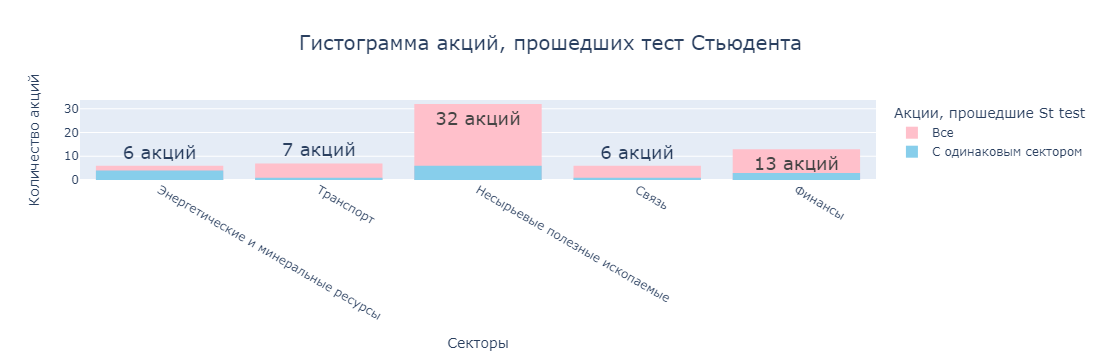

In [432]:
fig = go.Figure()

#Гистограмма всех акций
fig.add_trace(go.Histogram(
    x=sectors_st,
    name='Все',
    marker_color='pink',
    texttemplate="%{y} акций", textfont_size= 18
))

#Гистограмма акций, у которых совпал сектор
fig.add_trace(go.Histogram(
    x=sectors_t,
    name='С одинаковым сектором',
    marker_color='skyblue'
))

#Оформление названий гистграммы, осей, легенды
fig.update_layout(
    title_text='Гистограмма акций, прошедших тест Стьюдента', 
    title_font=dict(size=20),
    title_x = 0.5,
    xaxis_title_text='Cекторы',
    yaxis_title_text='Количество акций',
    legend_title_text='Акции, прошедшие St test')

fig.update_layout(barmode='overlay')
fig.show()

### Из гистограммы видно, что максимальное число совпадений по акциям это 6 из 32 в секторе Несырьевые полезные эскопаемые, а максимальный процент совпадений в одном секторе 66.6% в Энергетические и минеральные ресурсы 
### Можно сказать, что одинаковый прирост цен у двух акций не связан с их секторами. Исключением является лишь сектор Энергетические и минеральные ресурсы, который вероятно отклонился от тенденции из-за малой выборки (всего 6 акций)

## Дополнение к KS test
<a id="cell10"></a>

### Заодно посчитаем процент совпадения секторов у компаний, прошедших KS test
<a id="cell9"></a>

In [433]:
count_t, count_f = 0, 0
for ticker in tickets_pv_ks_h0:
    if cp[f'Сектор {ticker[0][0]}'].iloc[0] == cp[f'Сектор {ticker[0][1]}'].iloc[0]:
        count_t += 1
    else:
        count_f += 1
print(f'Процент совпадения секторов {round(count_t / (count_f + count_t), 4) * 100}%')

Процент совпадения секторов 100.0%


### У 100% компаний, прошедших тест Колмогорова-Смирнова совпадает сектор, но исходя из вышеупомянутой доли (St test), такой относительно высокий результат вероятно могу быть получен в результате нерепрезентативной выборки, то есть малого количества пар, прошедших KS test (всего 2 штуки)

# 3. Линейная регрессия
<a id="cell11"></a>

## Модель №1
<a id="cell12"></a>
* #### y - Средние цены MTS в течение года
* #### x - Средние цены в течение года остальных акций входядих в Индекс Московской Биржи (IMOEX)
* #### c - Вектор константы

In [434]:
price_columns = [column for column in cp if column.startswith('Средняя цена ')]

#Таблица со средними ценами всех акций кроме MTS
cp_not_mtss = cp[price_columns].drop('Средняя цена MTSS', axis=1)
#Добавим константу
cp_not_mtss = sm.add_constant(cp_not_mtss)

#Cтолбец средних цен МТС
cp_mtss = cp['Средняя цена MTSS']

#Cоздание модели Линейной регрессии
model_1 = sm.OLS(cp_mtss, cp_not_mtss).fit()

#Вывод отчета
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:      Средняя цена MTSS   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     672.1
Date:                Sun, 31 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:26:09   Log-Likelihood:                -1570.9
No. Observations:                 500   AIC:                             3236.
Df Residuals:                     453   BIC:                             3434.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -61.6280     21

## Результаты модели №1
<a id="cell20"></a>
* #### По Prob (F - statistic) коэффициенты модели в целом статистически значимы при уровне 5%
* #### R-squared близок к единице, что уже в целом неплохо
### При этом стандартные ошибки отклонения коэффициентов модели имеют разброс с разной размерностью. Изменим спецификацию модели, чтобы привести модель единым ценам

## Модель №2
<a id="cell13"></a>
* #### ln(y) - Логарифм средних цен MTS в течение года
* #### ln(x) - Логарифм средних цен в течение года остальных акций входядих в Индекс Московской Биржи (IMOEX)
* #### c - Вектор константы
## Интерпретация коэффициентов:
### При увелечении некоторой переменной xi (цены акции) на 1% происходит увеличение объясняемой переменной y в среднем при прочих равных условиях на βi%

In [435]:
price_columns = [column for column in cp if column.startswith('Средняя цена ')]

#Таблица со средними ценами всех акций кроме MTS
cp_not_mtss = cp[price_columns].drop('Средняя цена MTSS', axis=1)
cp_not_mtss = np.log(cp_not_mtss)
#Добавим константу
cp_not_mtss = sm.add_constant(cp_not_mtss)

#Cтолбец средних цен МТС
cp_mtss = cp['Средняя цена MTSS']
cp_mtss = np.log(cp_mtss)

#Cоздание модели Линейной регрессии
model_2 = sm.OLS(cp_mtss, cp_not_mtss).fit()

#Вывод отчета
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:      Средняя цена MTSS   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     669.4
Date:                Sun, 31 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:26:09   Log-Likelihood:                 1223.9
No. Observations:                 500   AIC:                            -2354.
Df Residuals:                     453   BIC:                            -2156.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6311      0

## Результаты модели №2
<a id="cell21"></a>
* #### По Prob (F - statistic) коэффициенты модели в целом статистически значимы при уровне 5%
* #### R-squared стал чуть больше чем в модели №1
* #### Стандартные ошибки пронормировались

## Модель №3
<a id="cell16"></a>

## Мультиколлинеарность
<a id="cell14"></a>
### Как известно, R-squared может быть близок к 1 не только потому, что модель хорошо предсказывает зависимые переменные, но и потому что в много переменных в том числе и незначимых.
### Проверим могут ли быть в моделе переменные, которые не вносят вклад в модель из-за зависимости с другими переменными. 
### Посмотрим на тепловую карту как на корреляционную матрицу логарифма цен акций
* #### Тепловая карта интерактивная, поэтому есть опция наводить курсор на ячейки и смотреть значения корреляций по соответствующим тикерам

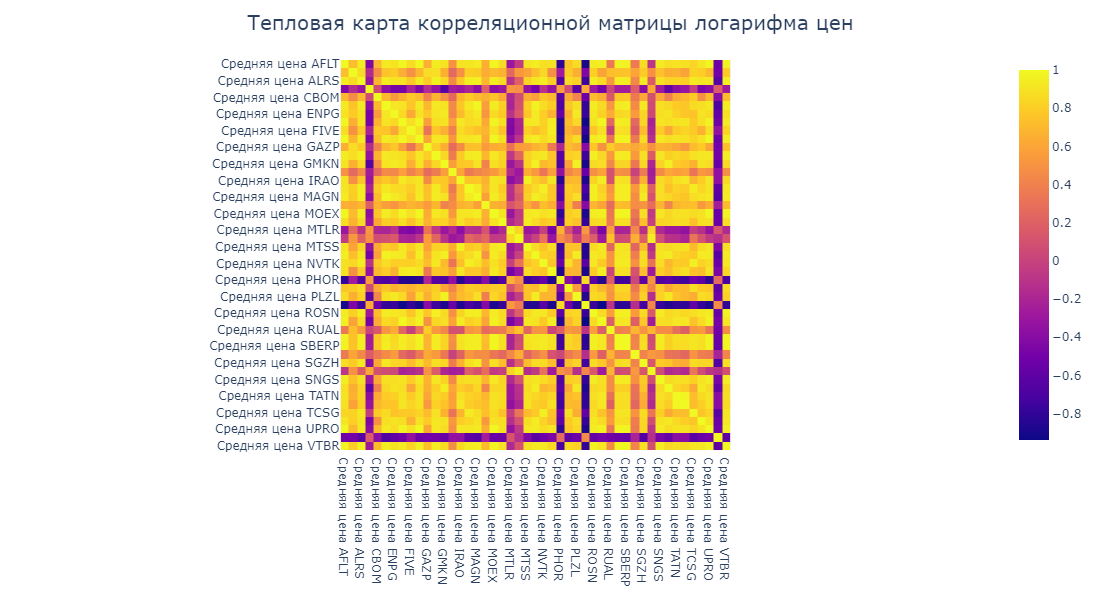

In [436]:
corrs = np.log(cp[price_columns]).corr()
fig = px.imshow(corrs)
fig.update_layout(height=600, width=700)
fig.update_layout(
    title_text='Тепловая карта корреляционной матрицы логарифма цен', 
    title_font=dict(size=20),
    title_x = 0.5)
fig.show()

### По желтому цвету видно, что в моделе много зависимых переменных, что говорит о высокой вероятности мультиколлинеарности о чем также говорит и коэффициент VIF > 10

In [437]:
print(f'VIF = {round(1 / (1 - model_2.rsquared), 2)} > 10')

VIF = 68.97 > 10


### Создаем регрессии из объясняющих приростов цен акций и будем удалять из исходной модели те тикеры, VIF по регрессии которых > 8

In [458]:
price_columns = [column for column in cp if column.startswith('Средняя цена ')]
#Таблица со средними ценами всех акций кроме MTS
models = []
cp_vif = cp
price_columns.remove('Средняя цена MTSS')
for ticker in corrs.columns:
    if ticker == 'Средняя цена MTSS':
        continue
    cp_not_ticker = cp_vif[price_columns].drop(ticker, axis=1)
    cp_not_ticker = np.log(cp_not_ticker)
    #Добавим константу
    cp_not_ticker = sm.add_constant(cp_not_ticker)
    
    #Cтолбец средних цен МТС
    cp_ticker = cp[ticker]
    cp_ticker = np.log(cp_ticker)

    vif = 1 / (1 - sm.OLS(cp_ticker, cp_not_ticker).fit().rsquared)
    if vif > 8:
        price_columns.remove(ticker)
        continue
    #Cоздание модели Линейной регрессии
    models.append([1 / (1 - sm.OLS(cp_ticker, cp_not_ticker).fit().rsquared), ticker])

In [459]:
corr_tickers = []
for model in models:
    corr_tickers.append(model[1])
#Таблица со средними ценами всех акций кроме MTS
cp_not_mtss = cp[corr_tickers]
cp_not_mtss = np.log(cp_not_mtss)
#Добавим константу
cp_not_mtss = sm.add_constant(cp_not_mtss)

#Cтолбец средних цен МТС
cp_mtss = cp['Средняя цена MTSS']
cp_mtss = np.log(cp_mtss)

#Cоздание модели Линейной регрессии
model_3 = sm.OLS(cp_mtss, cp_not_mtss).fit()

#Вывод отчета
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:      Средняя цена MTSS   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     779.3
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          1.10e-231
Time:                        15:36:09   Log-Likelihood:                 711.67
No. Observations:                 500   AIC:                            -1411.
Df Residuals:                     494   BIC:                            -1386.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0148      0

* #### Примечание: Коэффициенты VIF (variance inflation factor) показывают, насколько сильно связаны друг с другом регрессоры модели

In [440]:
print(f'R-squared {round(model_3.rsquared, 3)}',
      f'Количество удаленных переменных {len(model_2.params) - len(model_3.params)}', sep='\n')

R-squared 0.887
Количество удаленных переменных 41


### Заметим, что при достаточно близком к единице R-squared, в новой регрессии теперь гораздо ниже шанс наличия мультиколлинеарности, но за это пришлось удалить большинство тикеров из модели

### Также, заметим, что доля статистически значимых переменных по (P > |t|) при уровне 5% в моделе 3 уменьшилась по сравнению с той же долей в моделе 2 
<a id="cell17"></a>

In [447]:
print('Процент статистически значимых переменных в моделе:',
      f'В моделе №2: {round((model_2.pvalues < 0.05).sum() / len(model_2.pvalues) * 100, 2)} %',
      f'В моделе №3: {round((model_3.pvalues < 0.05).sum() / len(model_3.pvalues) * 100, 2)} %', sep='\n')

Процент статистически значимых переменных в моделе:
В моделе №2: 55.32 %
В моделе №3: 50.0 %


### Проверим наличие гетерероскедастичности в моделях №2 и №3

## Тест Уайта
<a id="cell15"></a>

In [460]:
#Тест Уайта для модели №2
white_test = het_white(model_2.resid , model_2.model.exog )
#Название переменных для отображения White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#Результаты White's test
print('Модель №2: p-value =', dict(zip(labels, white_test))['Test Statistic p-value'], '> 0.05')

#Тест Уайта для модели №3
white_test = het_white(model_4.resid , model_4.model.exog )
#Название переменных для отображения White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#Результаты White's test
print('Модель №3: p-value =', dict(zip(labels, white_test))['Test Statistic p-value'], '<< 0.05')

Модель №2: p-value = 0.4789716044812014 > 0.05
Модель №3: p-value = 4.60904021352729e-42 << 0.05


### Тест Уайта показал наличие гетероскедастичности на уровне значимости 5% в моделе №3 и ее отсутствие в моделе №2 

### Рассмотрим этот результат на графиках поведения остатков в каждой модели

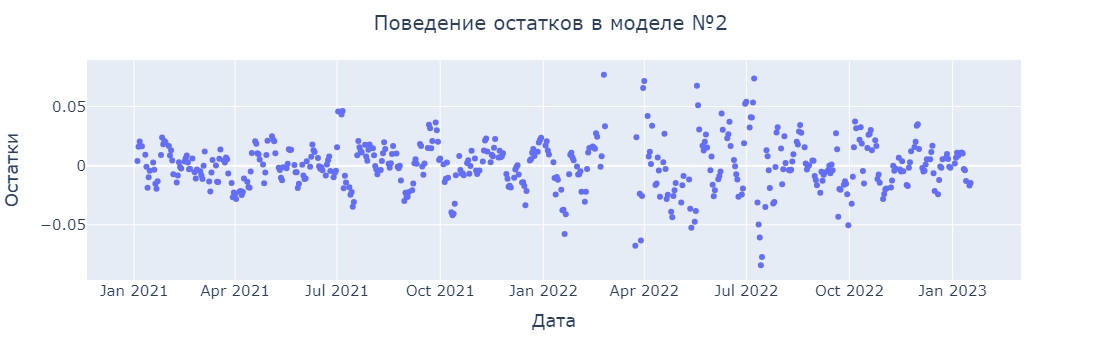

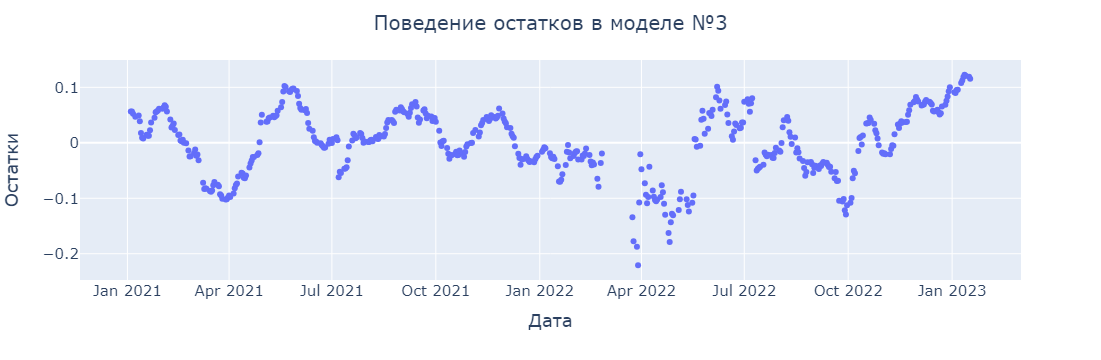

In [461]:
#Таблица с остатками моделей №2 и №3
df = pd.concat([model_2.resid, model_3.resid], axis=1)

#Процесс создания двух графиков, где num - это номер столбца
for num in range(2):
    fig = px.scatter(df, x=df.index, y=num)
    
    #Изменение оформления
    fig.update_layout(
        title_text=f'Поведение остатков в моделе №{num + 2}', 
        title_font=dict(size=20),
        title_x = 0.5,
        yaxis_title_text='Остатки',
        font = dict(size=15))
    
    fig.show()

## Результаты модели №3
<a id="cell30"></a>
* #### По Prob (F - statistic) коэффициенты модели в целом статистически значимы при уровне 5%
* #### R-squared стал ниже чем в модели №2
* #### Значительно снизилась вероятность наступления мультиколлинеарности
* #### Появилась Гетероскедастичность

## Модель №4
<a id="cell31"></a>

### Попробуем подобрать функциональную зависимость, которая является разностью между нашей оценкой и реальными значениями зависимой переменной

### Для этого изменим индексацию на периоды, руководствуясь тем, что мы выбирали некий базисный период t = 0 и от него подбираем функциональную зависимость остатков

### Добавим в модель cos(5*x ** 0.2 + 3), руководствуясь тем, что в экономике существуют циклы, подобно периодам в тригонометрических функциях

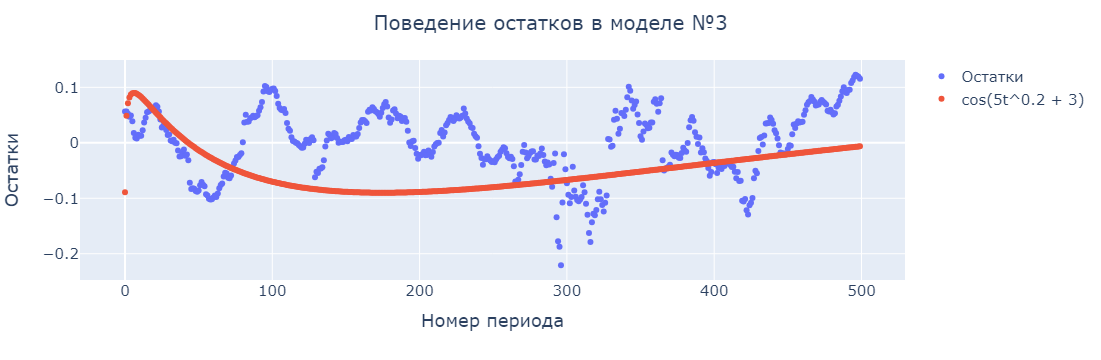

In [529]:
x = np.linspace(0, 10, len(cp))

# Вычисление значений синуса для каждого значения x
y = np.cos(5*x ** 0.2 + 3) * 0.09
#Таблица с остатками моделей №2 и №3
df = model_3.resid.reset_index(drop=True)
df_cos = pd.DataFrame({'cos(5t^0.2 + 3)': np.cos(5*x ** 0.2 + 3)*0.09})
df = pd.concat([df, df_cos], axis=1).rename(columns={0:'Остатки'})
#Процесс создания двух графиков, где num - это номер столбца
fig = px.scatter(df, x=list(df.index), y=['Остатки', 'cos(5t^0.2 + 3)'])
    
    #Изменение оформления
fig.update_layout(
        title_text=f'Поведение остатков в моделе №{num + 2}', 
        title_font=dict(size=20),
        title_x = 0.5,
        yaxis_title_text='Остатки',
        xaxis_title_text='Номер периода',
        font = dict(size=15),
        legend_title_text='')
    
fig.show()

In [519]:
corr_tickers = []
for model in models:
    corr_tickers.append(model[1])
#Таблица со средними ценами всех акций кроме MTS
cp_not_mtss_new = cp[corr_tickers].reset_index(drop=True)
df_cos = pd.DataFrame({'cos(5t^0.2 + 3)': np.cos(5*x ** 0.2 + 3)})
cp_not_mtss = pd.concat([np.log(cp_not_mtss_new), df_cos], axis=1)
#Добавим константу
cp_not_mtss = sm.add_constant(cp_not_mtss)

#Cтолбец средних цен МТС
cp_mtss = cp['Средняя цена MTSS'].reset_index(drop=True)
cp_mtss = np.log(cp_mtss)

#Cоздание модели Линейной регрессии
model_4 = sm.OLS(cp_mtss, cp_not_mtss).fit()
#Вывод отчета
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:      Средняя цена MTSS   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     708.1
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          1.16e-238
Time:                        16:07:57   Log-Likelihood:                 731.41
No. Observations:                 500   AIC:                            -1449.
Df Residuals:                     493   BIC:                            -1419.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4002      0

### Видим, что в моделе теперь все переменные статистически значимы при уровне 5%

### При этом, из графиков распределения остатков и теста Уайта видно, что гетерескедастичность осталась

In [505]:
#Тест Уайта для модели №2
white_test = het_white(model_3.resid , model_3.model.exog )
#Название переменных для отображения White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#Результаты White's test
print('Модель №3: p-value =', dict(zip(labels, white_test))['Test Statistic p-value'], '<< 0.05')

#Тест Уайта для модели №3
white_test = het_white(model_4.resid , model_4.model.exog )
#Название переменных для отображения White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#Результаты White's test
print('Модель №4: p-value =', dict(zip(labels, white_test))['Test Statistic p-value'], '<< 0.05')

Модель №3: p-value = 7.490926340801593e-36 << 0.05
Модель №4: p-value = 4.60904021352729e-42 << 0.05


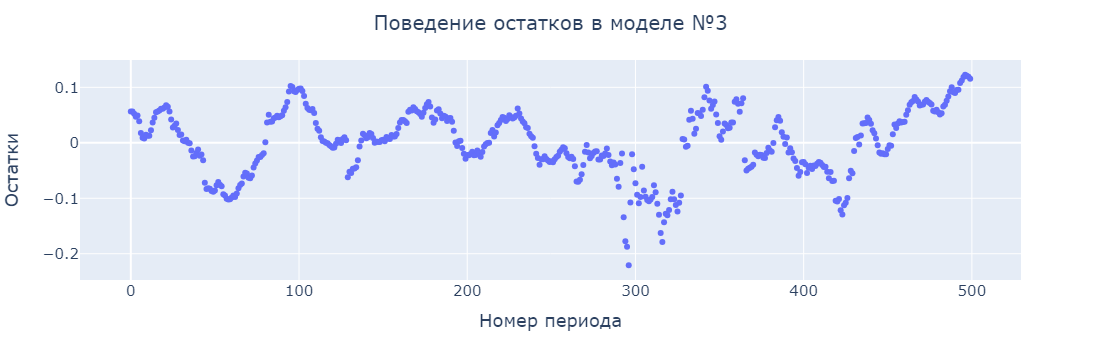

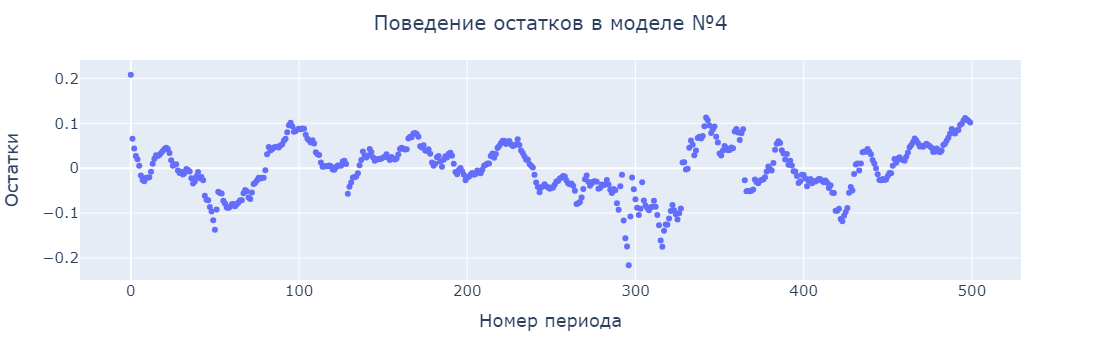

In [506]:
#Таблица с остатками моделей №2 и №3
model_3_resid = model_3.resid.reset_index(drop=True)
df = pd.concat([model_3_resid, model_4.resid], axis=1)

#Процесс создания двух графиков, где num - это номер столбца
for num in range(2):
    fig = px.scatter(df, x=df.index, y=num)
    
    #Изменение оформления
    fig.update_layout(
        title_text=f'Поведение остатков в моделе №{num + 3}', 
        title_font=dict(size=20),
        title_x = 0.5,
        yaxis_title_text='Остатки',
        xaxis_title_text='Номер периода',
        font = dict(size=15))
    
    fig.show()

## Результаты модели №4
<a id="cell32"></a>
* #### По Prob (F - statistic) коэффициенты модели в целом статистически значимы при уровне 5%
* #### R-squared стал чуть выше чем в моделе №2 и по проежнему близок к 1
* #### Все переменные статистически значимы
* #### Гетероскедастичность сохранилась

# Итоговая модель: [Модель №4](#cell13)
<a id="cell23"></a>
### Несмотря на то, что в моеделе №4 с высокой вероятностью может присутствовать гетероскедастичность, станадартные ошибки отклонения коэффциентов не так велики (до 3%). В отличие от других моделей она показывает наиболее высокую долю статистически значимых переменных на уровне 5% и отсутствие высокой вероятности наличия мультиколлинеарности